### Install Required Packages

We would be running `Stable Diffusion 2` so enable `GPU` under `View Resources > Change runtime type`

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-26474cf6-7b49-71b8-26a6-65f64dee4c09)


In [2]:
%%capture
!pip install diffusers
!pip install accelerate
!pip install daam==0.0.12
!pip install git+https://github.com/RishiDarkDevil/daam-i2i.git
!pip install git+https://github.com/RishiDarkDevil/TITAN.git

In [3]:
# !pip uninstall -y daami2i
# !pip uninstall -y daam
# !pip install git+https://github.com/RishiDarkDevil/daam-i2i.git

In [4]:
# !git clone https://github.com/RishiDarkDevil/daam-i2i.git
# %cd daam-i2i
# !git clone https://github.com/castorini/daam.git
# %cd daam

### Import Necessary Libraries

In [5]:
# Plotting
from matplotlib import pyplot as plt

# Data Handling
import numpy as np

# Image Processing
import cv2
from PIL import Image

# Image Generation
from diffusers import StableDiffusionPipeline

# Heatmap generation
import daam
import daami2i

# Model
import torch

# annotations
import titan

### Load Model

In [6]:
DEVICE = 'cuda' # device

Now, let's load the `stabilityai/stable-diffusion-2-base` diffusion model.

In [7]:
model = StableDiffusionPipeline.from_pretrained('stabilityai/stable-diffusion-2-base')
model = model.to(DEVICE) # Set it to something else if needed, make sure DAAM supports that

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

### DAAMI2I Image Attention

In [8]:
prompt = ['Indian cricket team playing at stadium with people cheering them.']

In [9]:
processed_prompt = titan.PromptHandler().clean_prompt(prompt)

Loading Models...

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


INFO:stanza:Downloading default packages for language: en (English) ...


INFO:stanza:Finished downloading models and saved to /root/stanza_resources.
INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| pos       | combined |
| lemma     | combined |

INFO:stanza:Using device: cuda
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Done loading processors!


Done
Tokenizing...Done
POS Tagging and Lemmatizing...Done
Processing...Done


In [10]:
# process the prompt for words, etc
prompt, cleaned_prompt, objects = processed_prompt[0]
processed_prompt

[('indian cricket team playing at stadium with people cheering them .',
  ['cricket', 'team', 'stadium', 'people'],
  ['cricket', 'team', 'stadium', 'people'])]

In [11]:
# prints image attn slice dims
# tracing all the attentions throughout the model while generating image
with daam.trace(model) as daam_trc, daami2i.trace(model, track_all=True) as daami2i_trc:
  output_image = model(prompt).images[0]
  image_all_heat_map = daami2i_trc
  word_all_heat_map = daam_trc

  0%|          | 0/51 [00:00<?, ?it/s]

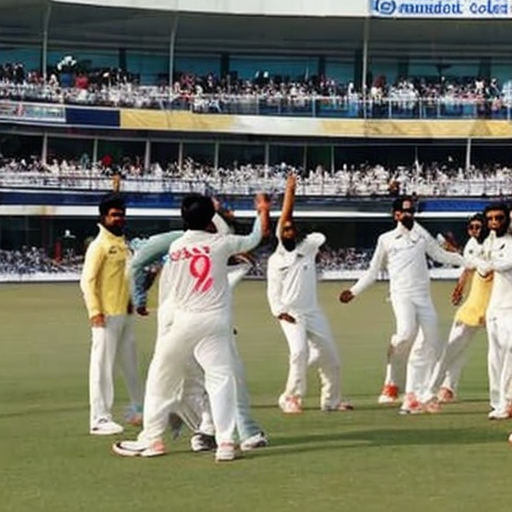

In [12]:
output_image

In [1]:
# image_all_heatmaps = dict(list(image_all_heat_map.all_heat_maps))

In [17]:
# image_all_heatmaps[(1,9,0)].cpu()

torch.Size([4096, 64, 64])

In [ ]:
# for v in image_all_heatmaps.values():
#   # print(v.shape)
#   # if v.shape[0] == 4096:
#   #   plt.imshow(v.cpu()[2000].numpy())
#   #   plt.show()
#   # if v.shape[0] == 1024:
#   #   plt.imshow(v.cpu()[488].numpy())
#   #   plt.show()
#   if v.shape[0] == 256:
#     plt.imshow(v.cpu()[116].numpy())
#     plt.show()

In [ ]:
# # OOM Error the appending of heatmap runs gpu out of memory in the append operation to all_merges
# image_global_heat_map = image_all_heat_map.compute_global_heat_map()
# word_global_heat_map = word_all_heat_map.compute_global_heat_map()

In [46]:
word_global_heat_map = word_all_heat_map.compute_global_heat_map()

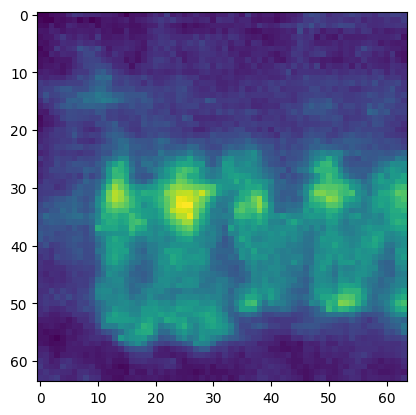

In [49]:
plt.imshow(word_global_heat_map.compute_word_heat_map(cleaned_prompt[1]).heatmap.cpu())

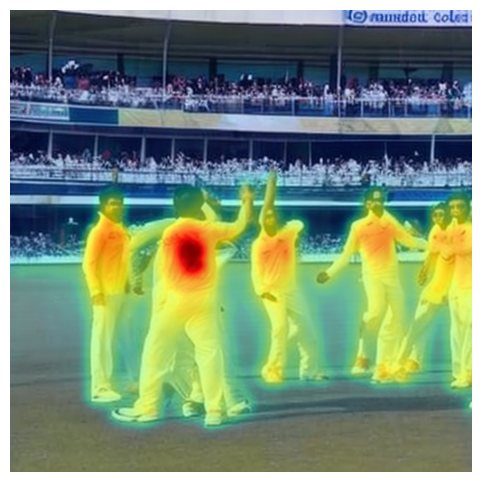

In [56]:
FHL_heat_map = image_all_heat_map.compute_global_heat_map([1], None, None)
FHL_heat_map.compute_guided_heat_map(
    word_global_heat_map.compute_word_heat_map(cleaned_prompt[1]).heatmap.cpu()
    ).plot_overlay(output_image, (6,6))

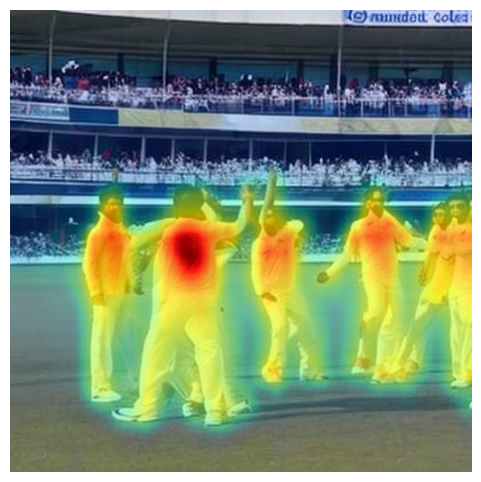

In [57]:
FHL_heat_map = image_all_heat_map.compute_global_heat_map([2], None, None)
FHL_heat_map.compute_guided_heat_map(
    word_global_heat_map.compute_word_heat_map(cleaned_prompt[1]).heatmap.cpu()
    ).plot_overlay(output_image, (6,6))

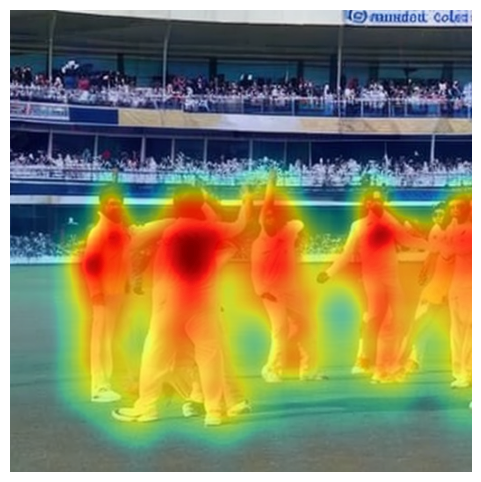

In [58]:
FHL_heat_map = image_all_heat_map.compute_global_heat_map([4], None, None)
FHL_heat_map.compute_guided_heat_map(
    word_global_heat_map.compute_word_heat_map(cleaned_prompt[1]).heatmap.cpu()
    ).plot_overlay(output_image, (6,6))

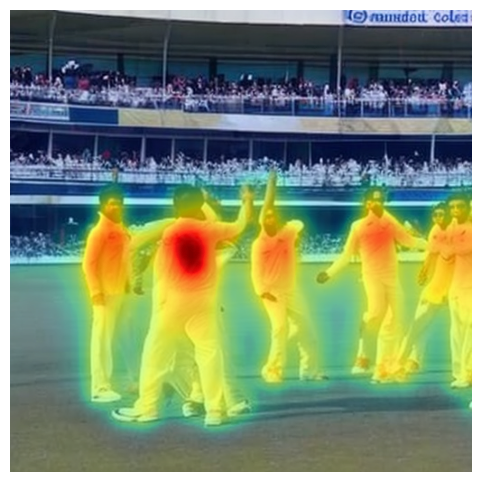

In [66]:
# # OOM Error the appending of heatmap runs gpu out of memory - Done not runs out of memory if all of these are not set to None
maps = torch.zeros((4096, 64, 64))
for factor in [1,2,4]:
  FHL_heat_map = image_all_heat_map.compute_global_heat_map([factor], None, None)
  maps += FHL_heat_map.heat_maps[FHL_heat_map.scale_correction(list(range(4096)))] / (2 ** factor) if factor != 1 else FHL_heat_map.heat_maps[FHL_heat_map.scale_correction(list(range(4096)))]
maps /= 3 
image_global_heat_map = daami2i.GlobalHeatMap(maps, 4096)

image_global_heat_map.compute_guided_heat_map(
    word_global_heat_map.compute_word_heat_map(cleaned_prompt[1]).heatmap.cpu()
    ).plot_overlay(output_image, (6,6))

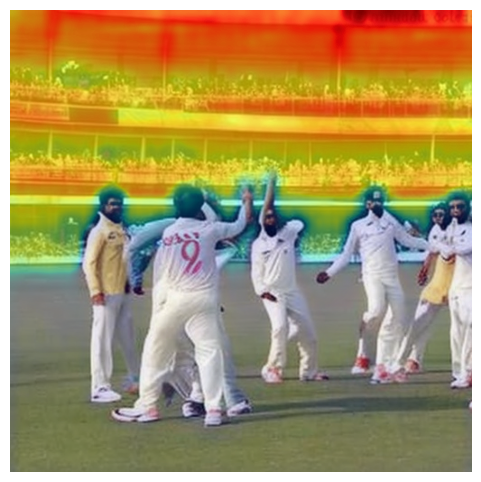

In [60]:
FHL_heat_map = image_all_heat_map.compute_global_heat_map([1], None, None)
FHL_heat_map.compute_guided_heat_map(
    word_global_heat_map.compute_word_heat_map(cleaned_prompt[2]).heatmap.cpu()
    ).plot_overlay(output_image, (6,6))

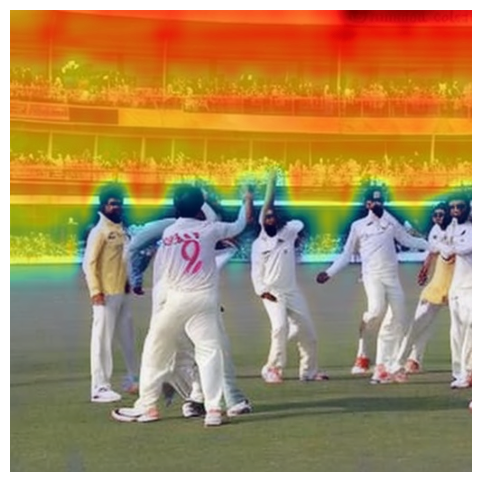

In [61]:
FHL_heat_map = image_all_heat_map.compute_global_heat_map([2], None, None)
FHL_heat_map.compute_guided_heat_map(
    word_global_heat_map.compute_word_heat_map(cleaned_prompt[2]).heatmap.cpu()
    ).plot_overlay(output_image, (6,6))

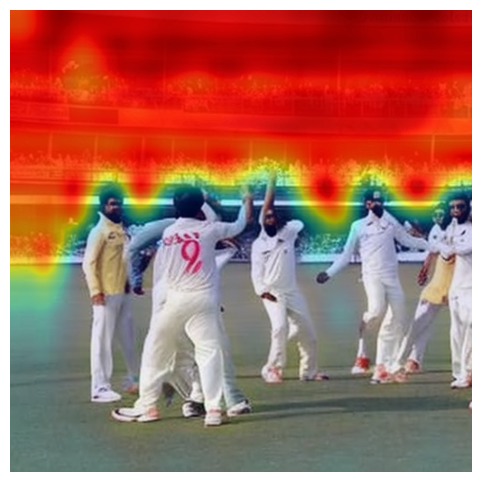

In [62]:
FHL_heat_map = image_all_heat_map.compute_global_heat_map([4], None, None)
FHL_heat_map.compute_guided_heat_map(
    word_global_heat_map.compute_word_heat_map(cleaned_prompt[2]).heatmap.cpu()
    ).plot_overlay(output_image, (6,6))

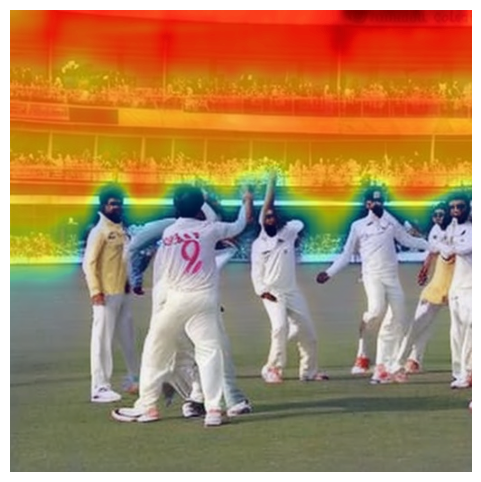

In [65]:
# # OOM Error the appending of heatmap runs gpu out of memory - Done not runs out of memory if all of these are not set to None
maps = torch.zeros((4096, 64, 64))
for factor in [1,2,4]:
  FHL_heat_map = image_all_heat_map.compute_global_heat_map([factor], None, None)
  maps += FHL_heat_map.heat_maps[FHL_heat_map.scale_correction(list(range(4096)))] / (2 ** factor) if factor != 1 else FHL_heat_map.heat_maps[FHL_heat_map.scale_correction(list(range(4096)))]
maps /= 3 
image_global_heat_map = daami2i.GlobalHeatMap(maps, 4096)

image_global_heat_map.compute_guided_heat_map(
    word_global_heat_map.compute_word_heat_map(cleaned_prompt[2]).heatmap.cpu()
    ).plot_overlay(output_image, (6,6))

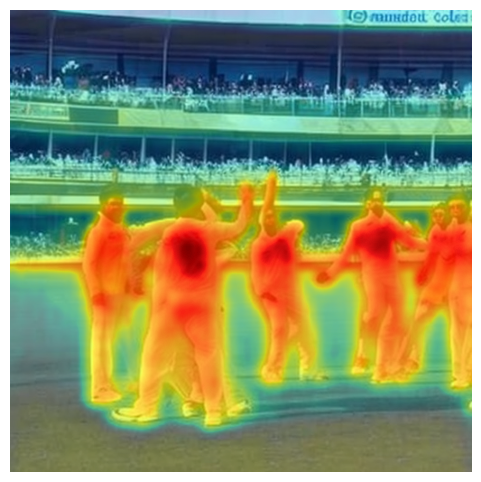

In [67]:
FHL_heat_map = image_all_heat_map.compute_global_heat_map([1], None, None)
FHL_heat_map.compute_guided_heat_map(
    word_global_heat_map.compute_word_heat_map(cleaned_prompt[3]).heatmap.cpu()
    ).plot_overlay(output_image, (6,6))

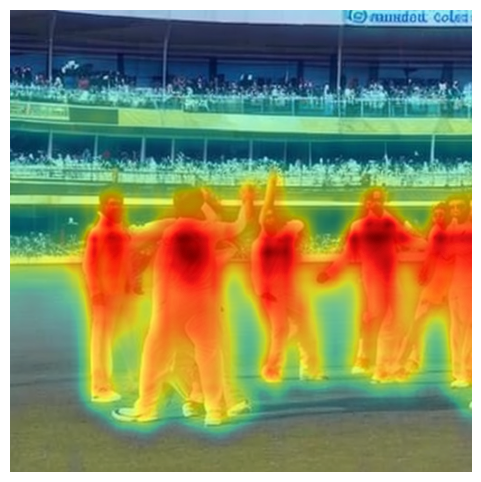

In [68]:
FHL_heat_map = image_all_heat_map.compute_global_heat_map([2], None, None)
FHL_heat_map.compute_guided_heat_map(
    word_global_heat_map.compute_word_heat_map(cleaned_prompt[3]).heatmap.cpu()
    ).plot_overlay(output_image, (6,6))

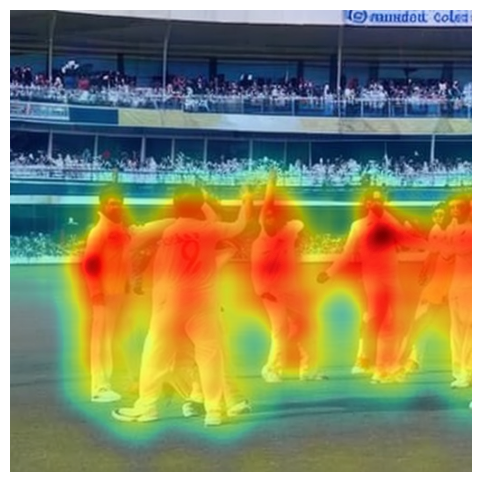

In [69]:
FHL_heat_map = image_all_heat_map.compute_global_heat_map([4], None, None)
FHL_heat_map.compute_guided_heat_map(
    word_global_heat_map.compute_word_heat_map(cleaned_prompt[3]).heatmap.cpu()
    ).plot_overlay(output_image, (6,6))

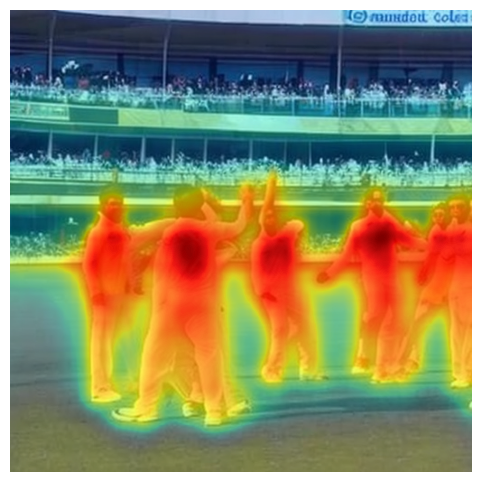

In [70]:
# # OOM Error the appending of heatmap runs gpu out of memory - Done not runs out of memory if all of these are not set to None
maps = torch.zeros((4096, 64, 64))
for factor in [1,2,4]:
  FHL_heat_map = image_all_heat_map.compute_global_heat_map([factor], None, None)
  maps += FHL_heat_map.heat_maps[FHL_heat_map.scale_correction(list(range(4096)))] / (2 ** factor) if factor != 1 else FHL_heat_map.heat_maps[FHL_heat_map.scale_correction(list(range(4096)))]
maps /= 3 
image_global_heat_map = daami2i.GlobalHeatMap(maps, 4096)

image_global_heat_map.compute_guided_heat_map(
    word_global_heat_map.compute_word_heat_map(cleaned_prompt[3]).heatmap.cpu()
    ).plot_overlay(output_image, (6,6))

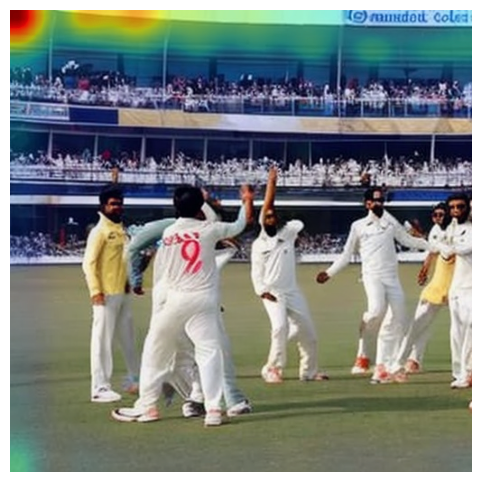

In [73]:
FHL_heat_map.compute_pixel_heat_map(1).plot_overlay(output_image, (6,6))

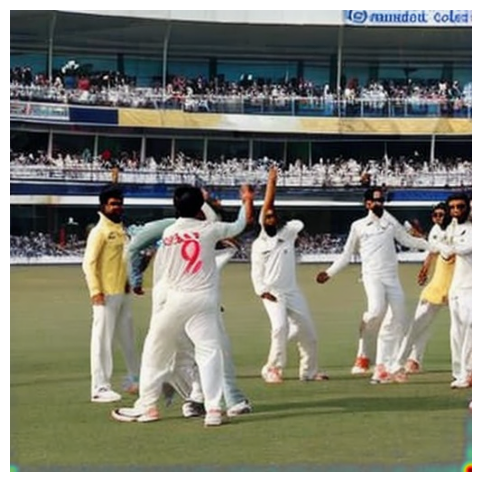

In [78]:
FHL_heat_map = image_all_heat_map.compute_global_heat_map([1], None, None)
FHL_heat_map.compute_pixel_heat_map(4095).plot_overlay(output_image, (6,6))

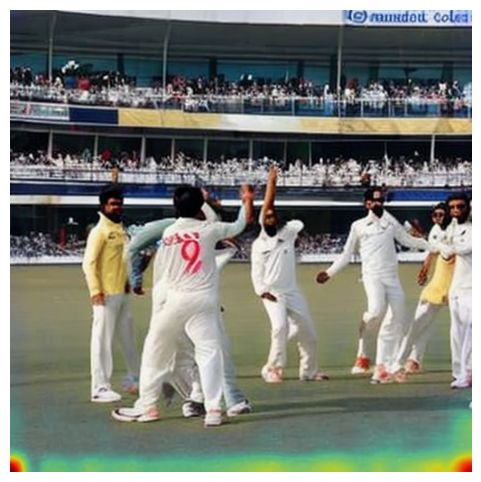

In [77]:
FHL_heat_map = image_all_heat_map.compute_global_heat_map([2], None, None)
FHL_heat_map.compute_pixel_heat_map(4095).plot_overlay(output_image, (6,6))

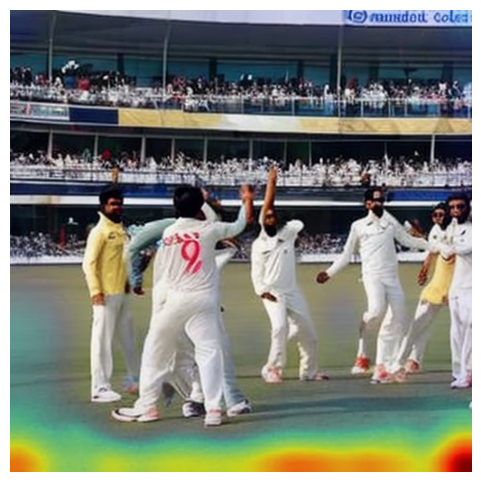

In [76]:
FHL_heat_map = image_all_heat_map.compute_global_heat_map([4], None, None)
FHL_heat_map.compute_pixel_heat_map(4095).plot_overlay(output_image, (6,6))

### Visualize Heatmaps

In [ ]:
# annotations = list()
object_annotator = titan.ObjectAnnotator()

In [ ]:
def plot_all(word):
  fig, ax = plt.subplots(2, 2, figsize=(12,12))
  fig.suptitle(f'Attention Heatmaps for {word}', fontsize=16)
  word_heatmap = word_global_heat_map.compute_word_heat_map(word)
  word_annotation = [ann['segmentation'] for ann in object_annotator.wordheatmap_to_annotations(word_heatmap.expand_as(output_image).numpy())]
  # Text2Image DAAM Heatmap
  ax[0,0].imshow(word_heatmap.expand_as(output_image).numpy())
  ax[0,0].axis('off')
  ax[0,0].set_title('DAAM')
  # Contour Image2Image Heatmap (DAAMI2I NW)
  ax[0,1].imshow(image_global_heat_map.compute_segmentation_heat_map(word_annotation, output_image.size[0], output_image.size[1]).expand_as(output_image).numpy())
  ax[0,1].axis('off')
  ax[0,1].set_title('DAAMI2I NW')
  # Guided Image2Image Heatmap (DAAMI2I W)
  ax[1,0].imshow(image_global_heat_map.compute_guided_heat_map(word_heatmap.heatmap).expand_as(output_image).numpy())
  ax[1,0].axis('off')
  ax[1,0].set_title('DAAMI2I W')
  # Contour + Guidance within Contour Image2Image Heatmap (DAAMI2I NW+W)
  ax[1,1].imshow(image_global_heat_map.compute_segmentation_heat_map(word_annotation, output_image.size[0], output_image.size[1], word_heatmap.heatmap).expand_as(output_image).numpy())
  ax[1,1].axis('off')
  ax[1,1].set_title('DAAMI2I NW+W')

In [ ]:
plot_all(cleaned_prompt[0])

In [ ]:
plot_all(cleaned_prompt[1])

In [ ]:
plot_all(cleaned_prompt[2])

In [ ]:
plot_all(cleaned_prompt[3])

In [ ]:
plot_all(cleaned_prompt[4])

### Object Detections

In [ ]:
def annotate_word(image, word_annotation):
  object_annotator.show_annotations(np.asarray(image), word_annotation, figsize=(10,10))
  plt.title(f'Object Detection for {word}')

In [ ]:
# DAAM base
word_heatmap = word_global_heat_map.compute_word_heat_map(cleaned_prompt[0])
word_annotation = object_annotator.wordheatmap_to_annotations(word_heatmap.expand_as(output_image).numpy())
annotate_word(output_image, word_annotation)

In [ ]:
# DAAMI2I NW
word_heatmap = word_global_heat_map.compute_word_heat_map(cleaned_prompt[0])
word_annotation = object_annotator.wordheatmap_to_annotations(
    image_global_heat_map.compute_segmentation_heat_map(word_annotation, output_image.size[0], output_image.size[1]).expand_as(output_image).numpy()
)
annotate_word(output_image, word_annotation)

In [ ]:
# DAAMI2I W
word_heatmap = word_global_heat_map.compute_word_heat_map(cleaned_prompt[0])
word_annotation = object_annotator.wordheatmap_to_annotations(
    image_global_heat_map.compute_guided_heat_map(word_heatmap.heatmap).expand_as(output_image).numpy()
)
annotate_word(output_image, word_annotation)

In [ ]:
# DAAMI2I NW+W
word_heatmap = word_global_heat_map.compute_word_heat_map(cleaned_prompt[0])
word_annotation = object_annotator.wordheatmap_to_annotations(
    image_global_heat_map.compute_segmentation_heat_map(word_annotation, output_image.size[0], output_image.size[1], word_heatmap.heatmap).expand_as(output_image).numpy()
)
annotate_word(output_image, word_annotation)